In [1]:
import matplotlib.pyplot as plt
import open3d as o3d
import sys
import numpy as np
sys.path.append("../..")
sys.path.append("..")   
from data.utils import distinct_colors
from models.datasets import SorghumDatasetWithNormals
from data.load_raw_data import load_pcd_plyfile_new_approach

plt.style.use('seaborn')

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


<hr>

# Semantic Segmentation Figures

In [40]:
ply_file = load_pcd_plyfile_new_approach("/space/ariyanzarei/sorghum_segmentation/dataset/archive/synthetic/2022-12-26/PointCloud/Season11_38788.ply", False)

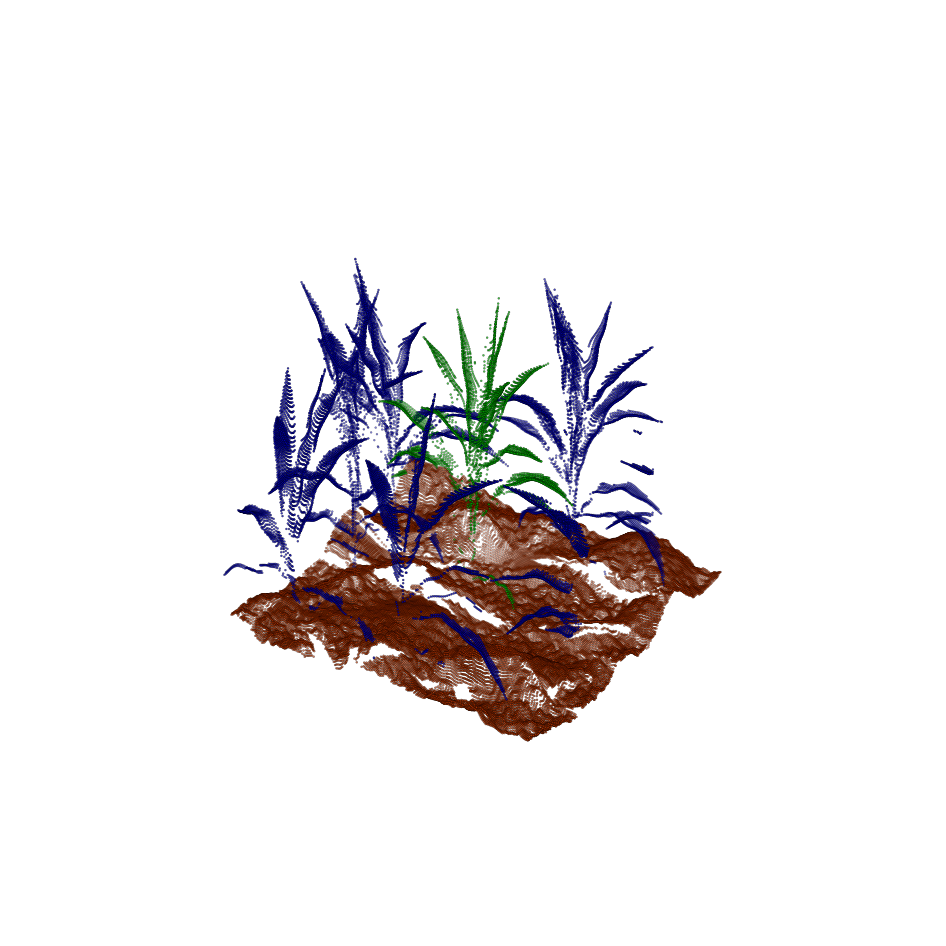

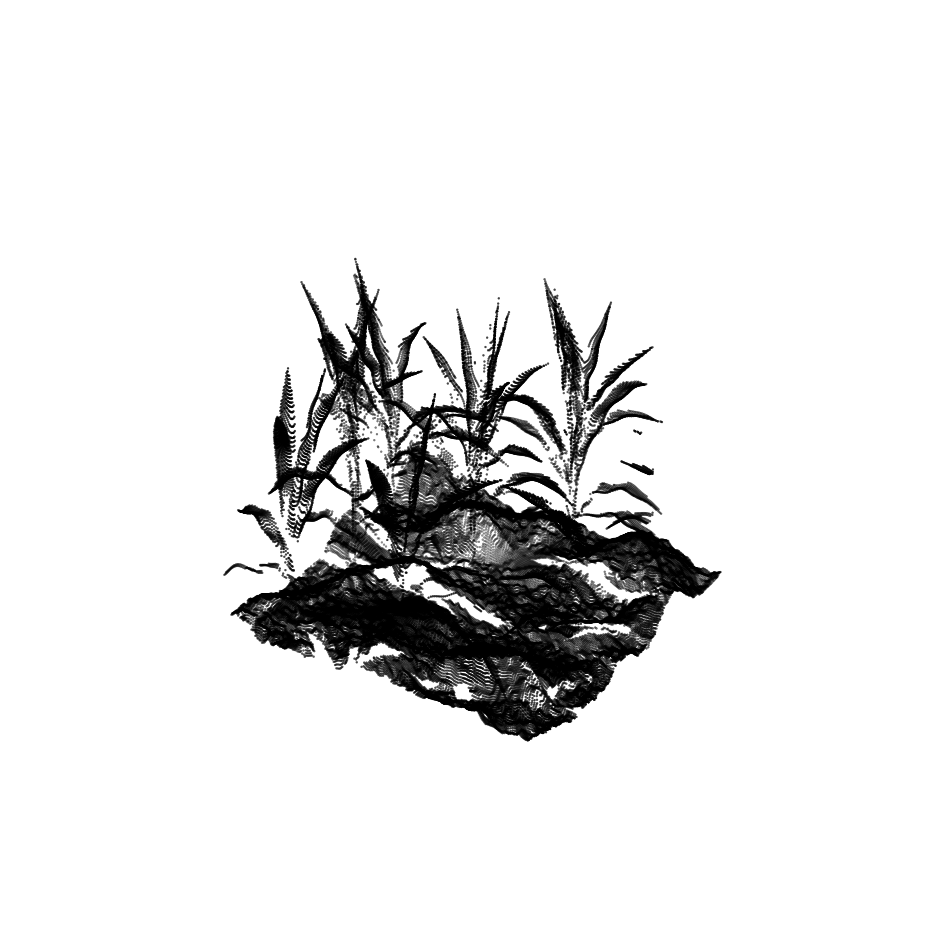

In [62]:
points, label = ply_file['points_full'], ply_file['labels_full'].squeeze()

d_colors = [[0.7, 0.2, 0], [0, 0.7, 0], [0, 0, 0.7]]
colors = np.zeros((label.shape[0],3))
for i, l in enumerate(list(set(label))):
    colors[label == l, :] = d_colors[i]


fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(projection='3d')
ax.scatter(points[:,0],points[:,1],points[:,2], s=3, c=colors)
ax.grid(False)
ax.axis("off")
ax.set_facecolor("white")
plt.show()

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(projection='3d')
ax.scatter(points[:,0],points[:,1],points[:,2], s=3, c='black')
ax.grid(False)
ax.axis("off")
ax.set_facecolor("white")
plt.show()

<hr>

# Instance Segmentation Figures

In [2]:
ply_file = load_pcd_plyfile_new_approach("/space/ariyanzarei/sorghum_segmentation/dataset/archive/synthetic/2022-12-26/PointCloud/Season11_38788.ply", True)

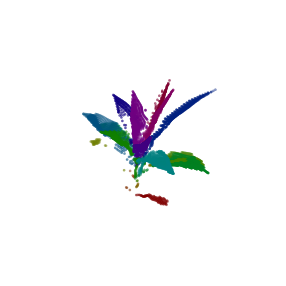

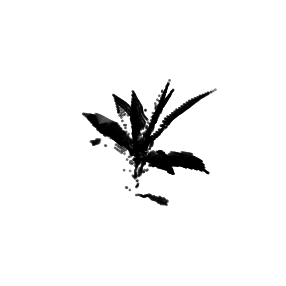

In [6]:
points, label = ply_file['points_full'], ply_file['labels_full'].squeeze()

d_colors = distinct_colors(len(list(set(label))))
colors = np.zeros((label.shape[0],3))
for i, l in enumerate(list(set(label))):
    colors[label == l, :] = d_colors[i]


fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(projection='3d')
ax.scatter(points[:,0],points[:,1],points[:,2], s=5, c=colors)
ax.grid(False)
ax.axis("off")
ax.set_facecolor("white")
plt.show()

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(projection='3d')
ax.scatter(points[:,0],points[:,1],points[:,2], s=5, c='black')
ax.grid(False)
ax.axis("off")
ax.set_facecolor("white")
plt.show()

<hr>

# PCA to visualize the embedding space

In [1]:
from sklearn.decomposition import PCA 
import sys
sys.path.append("..")
from models.nn_models import SorghumPartNetInstance
from data.load_raw_data import load_pcd_plyfile_new_approach
import torch
import numpy as np
import matplotlib.pyplot as plt
from data.utils import distinct_colors

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# sorghumpartnet = SorghumPartNetInstance.load_from_checkpoint("/speedy/ariyanzarei/sorghum_segmentation/results/training_logs/SorghumPartNetInstance/SPNS/EXP_08/checkpoints/epoch=8-step=43199.ckpt")
# sorghumpartnet = sorghumpartnet.cpu()
# sorghumpartnet.DGCNN_feature_space.device = "cpu"

sorghumpartnet = SorghumPartNetInstance.load_from_checkpoint("/speedy/ariyanzarei/sorghum_segmentation/results/training_logs/SorghumPartNetInstance/SPNS/EXP_09/checkpoints/epoch=8-step=43199.ckpt")
sorghumpartnet = sorghumpartnet.cpu()
sorghumpartnet.DGCNN_feature_space.device = "cpu"

In [3]:
ply_file = load_pcd_plyfile_new_approach("/space/ariyanzarei/sorghum_segmentation/dataset/archive/synthetic/2022-12-26/PointCloud/Season11_38788.ply", True)
points, label = ply_file['points'], ply_file['labels'].squeeze()

In [4]:
preds = sorghumpartnet(torch.from_numpy(points).type(torch.DoubleTensor).unsqueeze(0).cpu())
preds = preds.squeeze().cpu().detach().numpy()

In [5]:
k = 200
tensor_points = torch.from_numpy(points).type(torch.DoubleTensor).unsqueeze(0).cpu()
gt_clusters = torch.from_numpy(label).type(torch.FloatTensor).cpu()

num_points = gt_clusters.size(0)
num_dims = 1

distance = torch.cdist(tensor_points, tensor_points)
# idx = torch.topk(distance, k, -1)[1]
# idx = idx.squeeze()

# gt_clusters = gt_clusters.contiguous()

# knn_gt_labels = gt_clusters[idx]
# knn_gt_labels = knn_gt_labels.view(num_points, k)

# std_knn_gt_labels = torch.std(knn_gt_labels, 1)
# std_knn_gt_labels = (std_knn_gt_labels/std_knn_gt_labels.max())*0.8+0.2

distance = (distance.squeeze()<0.15)

count_knn_gt_labels = torch.zeros(num_points)
for i in range(num_points):
    tmp = torch.unique(gt_clusters[distance[i]], return_counts=True)[1]
    count_knn_gt_labels[i] = tmp.shape[0]

In [6]:
print(count_knn_gt_labels.min(), count_knn_gt_labels.max())
max_count = count_knn_gt_labels.max().int().item()

tensor(1.) tensor(14.)


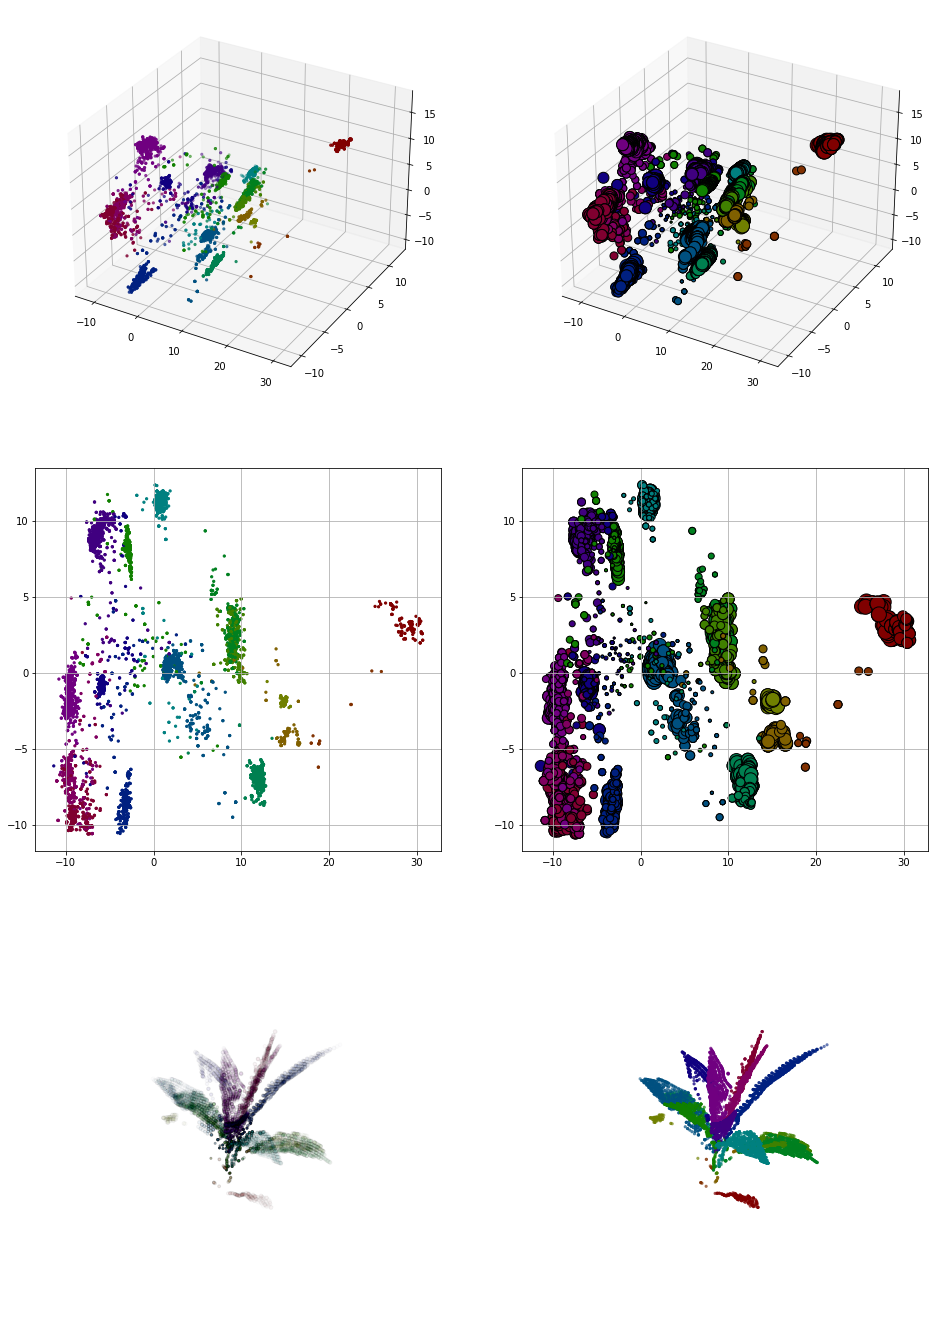

In [7]:
pca_3d = PCA(n_components = 3)
pca_3d.fit(preds)
data_pca_3d = pca_3d.transform(preds)

pca_2d = PCA(n_components = 2)
pca_2d.fit(preds)
data_pca_2d = pca_2d.transform(preds)

d_colors = distinct_colors(len(list(set(label))))
colors = np.zeros((label.shape[0],3))
for i, l in enumerate(list(set(label))):
    colors[label == l, :3] = d_colors[i]

    
fig = plt.figure(figsize=(16,24))

ax1 = fig.add_subplot(3,2,1,projection='3d')
ax1.scatter(data_pca_3d[:,0],data_pca_3d[:,1],data_pca_3d[:,2], s=5, c=colors)
ax1.grid(True)
ax1.set_facecolor("white")

ax2 = fig.add_subplot(3,2,2,projection='3d')
for i in range(count_knn_gt_labels.max().int().item()):
    ind = count_knn_gt_labels==(i+1)
    ax2.scatter(data_pca_3d[ind,0],data_pca_3d[ind,1],data_pca_3d[ind,2], s=(max_count-i+1)**2, c=colors[ind], marker='o', edgecolors='black', linewidth=1, alpha=1)

ax2.grid(True)
ax2.set_facecolor("white")

ax3 = fig.add_subplot(3,2,3)
ax3.scatter(data_pca_2d[:,0],data_pca_2d[:,1], s=5, c=colors)
ax3.grid(True)
ax3.set_facecolor("white")

ax4 = fig.add_subplot(3,2,4)
for i in range(count_knn_gt_labels.max().int().item()):
    ind = count_knn_gt_labels==(i+1)
    ax4.scatter(data_pca_2d[ind,0],data_pca_2d[ind,1], s=(max_count-i+1)**2, c=colors[ind], marker='o', edgecolors='black', linewidth=1, alpha=1)

ax4.grid(True)
ax4.set_facecolor("white")

ax5 = fig.add_subplot(3,2,5,projection='3d')
for i in range(max_count):
    ind = count_knn_gt_labels==(i+1)
    ax5.scatter(points[ind,0],points[ind,1],points[ind,2], s=(max_count-i+1)**1, c=colors[ind], marker='o', edgecolors='black', linewidth=1, alpha=0.75**(max_count-i+1))
ax5.grid(False)
ax5.axis("off")
ax5.set_facecolor("white")

ax6 = fig.add_subplot(3,2,6,projection='3d')
ax6.scatter(points[:,0],points[:,1],points[:,2], s=5, c=colors)
ax6.grid(False)
ax6.axis("off")
ax6.set_facecolor("white")
plt.show()